In [1]:
##deepDepth_double_self_consistency_check-separable-color-REG-V2

from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Reshape, Lambda, merge
from keras.layers import Dropout
from keras.layers.convolutional import SeparableConv2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from PIL import Image
from tqdm import tqdm as tqdm

% matplotlib inline
# from data import load_train_data, load_test_data

Using TensorFlow backend.


First lets load some of our stereo data, check out what it looks like:

found 65 images


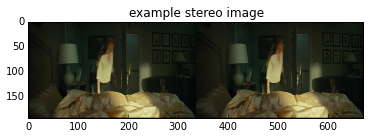

image shape: (192, 672, 3)


In [2]:

stereo_image_files = glob('train/train/*')[::100]
    
print('found {} images'.format(len(stereo_image_files)))
stereo_im = mpimg.imread(stereo_image_files[10])
plt.imshow(stereo_im)
plt.title('example stereo image')
plt.show()
print('image shape: {}'.format(stereo_im.shape))

img_rows, img_cols = stereo_im.shape[0], stereo_im.shape[1]/2

We'll have to split the stereo image into the left and right eye:

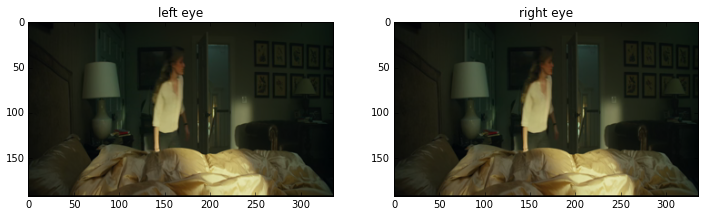

left image size: (192, 336, 3)


In [3]:
im_left = stereo_im[:,:img_cols,:]
im_right = stereo_im[:,img_cols:,:]

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(im_left)
plt.title('left eye')
plt.subplot(1,2,2)
plt.imshow(im_right)
plt.title('right eye')
plt.show()

print('left image size: {}'.format(im_left.shape))


Lets pack our images into a format appropriate for training: split stero images into left,right pairs and convert them to gray scale. We also crop the images so that the sizes work out when downsampling and upsampling back to original shape in the unet network.

In [4]:

X = []
for image_path in tqdm(stereo_image_files):
    # open and convert to grayscale:
    stereo_im = Image.open(image_path)
    # convert to numpy array
    stereo_im = np.asarray(stereo_im)
    
    im_left, im_right = stereo_im[:,:img_cols,:3], stereo_im[:,img_cols:, :3]
    im_left, im_right = im_left[:img_rows, :img_cols,:3], im_right[:img_rows, :img_cols, :3]
    
    # concatenate left/right eye images along the channel axis
    X += [np.concatenate([im_left, im_right], axis=2).astype('float32')/255.0]

X = np.stack(X)
print('X length: {}'.format(len(X)))
print('X[0] shape: {}'.format(X[0].shape))

100%|██████████| 65/65 [00:01<00:00, 44.16it/s]

X length: 65
X[0] shape: (192, 336, 6)


Let's plot one of these input images, we'll plot each channel in a separate figure:

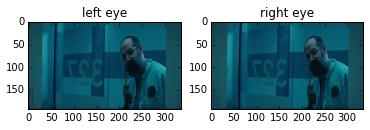

In [5]:
im_left, im_right = X[2][...,:3], X[2][...,3:]
plt.subplot(1,2,1)
plt.imshow(im_left, cmap=plt.cm.gray)
plt.title('left eye')
plt.subplot(1,2,2)
plt.imshow(im_right, cmap=plt.cm.gray)
plt.title('right eye')
plt.show()

Looking good! 

Lets now build a Unet-type model, a fully convolutional net with residual connections that will take in both images as input. We will slightly modify it to include batchNormalization. Two strategies possible: construct one tower per eye, and merge with a concatenation along the feature axis, or input the two images as two different channel of a single image.

We will try the second option first: using grayscale version of the images, our input will be a single image with two channels: left and right eye images.

First, we will build a Unet-type model ([U-Net: Convolutional Networks for Biomedical Image Segmentation] to compute the disparty map from the stereo pair.
The architecture is follows:
(http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)):

![alt text](network.png)

The treaky part is to build a selection layer as described in [deep3d](https://arxiv.org/abs/1604.03650). 
Our network predicts a probability distribution across possible disparity values d (with $d \in \left[-3,8 \right]$) at each pixel location $D^{d}_{i,j}$ , where $\sum_{d}P^{d}_{i,j} = 1$ for all $i, j$. To get the right image from the left image and the disparity map, and check that the disparity map is correct, we first define a shifted stack of the left view as $L^{d}_{i,j}= L_{i,j-d}$, then we use the disparity map $D^{d}_{i,j}$ to calculate the right image as:

$$ R_{i,j} = \sum_{d} L^{d}_{i,j} D^{d}_{i,j} \;\;\;\;\;\;\;\;\;\;\;\;   (1)$$

This is differentiable with respect to $D^{d}_{i,j}$. This means that we will be able to train the network using backpropagation to modify the disparity map infered from both the left and right image until it is correct, e.g. we can properly reconstruct the right image from the left image and the disparity map using the equation above.

To that end, we must first create an this "geometry expert" layer using tensorflow/keras that will perform the simple operation in eq (1). This layer will not contain any learnable weight, its output is completely deterministic given an image and a disparity map. Its only role is to contain information about the simple geometric rules that allow one to calculate right image from left and disparity. This infusion of expert knowledge is all the network should need to start being able to compute depth from pairs of images. 


This layer needs to do the following:

* construct the shifted left image stack $L^{d}_{i,j}= L_{i,j-d}$
* compute the right image by performing a dot product along the disparity values axis $d$ as $ R_{i,j} = \sum_{d} L^{d}_{i,j} D^{d}_{i,j}$


Lets build a custom keras layer that implements these operations:

In [6]:
from keras.engine.topology import Layer
import numpy as np

class Selection(Layer):

    def __init__(self, disparity_levels=None, **kwargs):
        # if none, initialize the disparity levels as described in deep3d
        if disparity_levels is None:
            disparity_levels = range(-16,16,1)
            
        super(Selection, self).__init__(**kwargs)
            
        self.disparity_levels = disparity_levels

    def build(self, input_shape):
        # Used purely for shape validation.
        if not isinstance(input_shape, list) or len(input_shape) != 2:
            raise ValueError('A `Selection` layer should be called '
                             'on a list of 2 inputs.')
            

    def call(self, inputs):
        
        # first we extract the left image from the original input
        image = inputs[0]
        # then the calculated disparity map that is the ouput of the Unet
        disparity_map = inputs[1]
        # initialize the stack of shifted left images
        shifted_images = []
        # loop over the different disparity levels and shift the left image accordingly, add it to the list
        for shift in self.disparity_levels:
            if shift > 0:
                shifted_images += [K.concatenate([image[..., shift:,:], K.zeros_like(image[..., :shift,:])], axis=2)]
            elif shift < 0:
                shifted_images += [K.concatenate([K.zeros_like(image[..., shift:,:]), image[..., :shift,:]], axis=2)]
            else:
                shifted_images += [image]
        
        # create a tensor of shape (None, im_rows, im_cols, disparity_levels)
        shifted_images_stack = K.stack(shifted_images)
        shifted_images_stack = K.permute_dimensions(shifted_images_stack, (1,2,3,0,4))
        
        # take the dot product with the disparity map along the disparity axis
        # and output the resulting right image of size (None, im_rows, im_cols)
        new_image = []
        for ch in range(3):
            new_image += [K.sum(shifted_images_stack[...,ch]*disparity_map, axis=3)]
            
        new_image = K.stack(new_image)
        new_image = K.permute_dimensions(new_image, (1,2,3,0))
            
        return new_image

    def compute_output_shape(self, input_shape):
        return input_shape[0]

We test our custom layer by inputing some dummy data and check is the initialization and the call method function as they are supposed to. For that, we use the left image we loaded earlier, and check for a few disparity levels if the image if shifted correctly:
(very slow because of communication overhead between Python and Tensorflow in sess.run, which is executed multiple times inside this simple check snipet)

100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


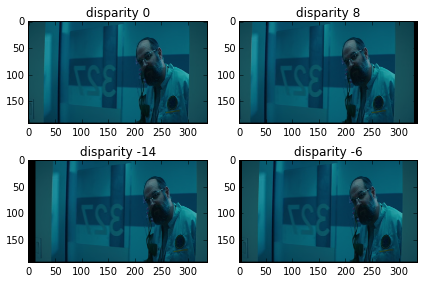

100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


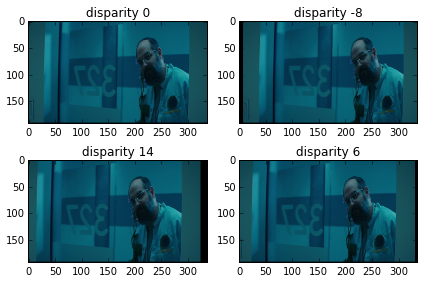

In [7]:
selectLayer = Selection(disparity_levels= range(-15,15,1))
selectLayer.build([(None,img_rows,img_cols,2), (None, img_rows, img_cols,3, 30)])

plt.figure()
for n, disp_level in enumerate(tqdm(range(-15,15,8))):
    disparity = np.zeros((1,img_rows,img_cols,30))
    disparity[...,disp_level] = 1.0
    disparity = K.variable(disparity)
    left_image = K.variable(np.expand_dims(im_left,0).astype('float32'))

    right_im = selectLayer.call([left_image, disparity])
    im_right = K.eval(right_im)
    
    plt.subplot(2,2,n+1)
    plt.imshow(im_right[0])
    plt.title('disparity {}'.format(selectLayer.disparity_levels[disp_level]))
    
plt.tight_layout()
plt.show()

selectLayer = Selection(disparity_levels= range(15,-15,-1))
selectLayer.build([(None,img_rows,img_cols,2), (None, img_rows, img_cols, 12)])

plt.figure()
for n, disp_level in enumerate(tqdm(range(-15,15,8))):
    disparity = np.zeros((1,img_rows,img_cols,30))
    disparity[...,disp_level] = 1.0
    disparity = K.variable(disparity)
    left_image = K.variable(np.expand_dims(im_left,0).astype('float32'))

    right_im = selectLayer.call([left_image, disparity])
    im_right = K.eval(right_im)
    
    plt.subplot(2,2,n+1)
    plt.imshow(im_right[0])
    plt.title('disparity {}'.format(selectLayer.disparity_levels[disp_level]))
    
plt.tight_layout()
plt.show()

In [8]:
from keras.engine.topology import Layer
import numpy as np

class Gradient(Layer):

    def __init__(self, **kwargs):
        # if none, initialize the disparity levels as described in deep3d
        super(Gradient, self).__init__(**kwargs)
            
    def build(self, input_shape):
        # Used purely for shape validation.
        pass

    def call(self, inputs):
        
        dinputs_dx_0 = inputs - K.concatenate( [K.zeros_like(inputs[..., :1,:]), inputs[..., :-1,:]], axis=1)
        dinputs_dx_1 = inputs - K.concatenate( [inputs[..., 1:,:], K.zeros_like(inputs[..., :1,:])], axis=1)
        
        dinputs_dy_0 = inputs - K.concatenate( [K.zeros_like(inputs[..., :1]), inputs[..., :-1]], axis=2)
        dinputs_dy_1 = inputs - K.concatenate( [inputs[..., 1:], K.zeros_like(inputs[..., :1])], axis=2)
        
        abs_gradient_sum = 0.25*K.sqrt(K.square(dinputs_dx_0)+K.square(dinputs_dx_1)+K.square(dinputs_dy_0)+K.square(dinputs_dy_1))
        
        return abs_gradient_sum[...,2:-2,2:-2]
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1]-4,input_shape[2]-4)

In [9]:
im_left, im_right = X[3][...,:3], X[3][...,3:]

gradientLayer = Gradient()
gradientLayer.build((None,img_rows,img_cols))

left_image = K.variable(np.expand_dims(im_left.mean(axis=2),0).astype('float32'))
gradient = gradientLayer.call(left_image)
gradient = K.eval(gradient)
print(gradient.shape, gradient.min(), gradient.max())
gradient /= gradient.max()
# gradient[gradient>0.4] = 1.0
# gradient[gradient<0.4] = 0.0
# plt.imshow(gradient[0])
# plt.colorbar()
# plt.show()

# plt.imshow(im_right)
# # plt.title('right eye')
# plt.show()



(1, 188, 332) 0.0 0.204328


In [10]:
from keras.engine.topology import Layer
import numpy as np

class Depth(Layer):

    def __init__(self, disparity_levels=None, **kwargs):
        # if none, initialize the disparity levels as described in deep3d
        if disparity_levels is None:
            disparity_levels = range(-3,9,1)
            
        # if none, initialize the disparity levels as described in deep3d
        super(Depth, self).__init__(**kwargs)
        
        self.disparity_levels = disparity_levels
            
    def build(self, input_shape):
        # Used purely for shape validation.
        pass
            

    def call(self, disparity):
        
        depth = []
        for n, disp in enumerate(self.disparity_levels):
            depth += [disparity[...,n]*disp]
        
        depth = K.concatenate(depth, axis=0)
        return K.sum(depth, axis=0, keepdims=True)
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

(1, 96, 128) 0.0 0.0


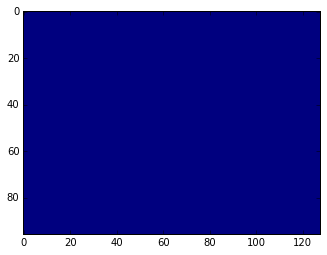

In [11]:
depthLayer = Depth()
depthLayer.build((None,img_rows,img_cols,12))

disparity_map = K.variable(np.zeros((1,96,128,12)))
depth = depthLayer.call(disparity_map)
depth = K.eval(depth)
print(depth.shape, depth.min(), depth.max())
plt.imshow(depth[0])
plt.show()


Looking great! Now let's try to build and compile the entire model:

In [40]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

def get_unet(img_rows, img_cols, lr=1e-4):
    inputs = Input((img_rows, 2*img_cols, 3)) #2 channels: left and right images
    
    # split input left/right wise
    left_input_image = Lambda(lambda x : x[...,:img_cols,:])(inputs)
    right_input_image = Lambda(lambda x : x[...,img_cols:,:])(inputs)
    
    concatenated_images = concatenate([left_input_image, right_input_image], axis=3)
    
    conv1 = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(concatenated_images)
    conv1 = BatchNormalization()(conv1)
    conv1 = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = SeparableConv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = SeparableConv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(rate=0.4)(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(rate=0.4)(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(rate=0.4)(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Dropout(rate=0.4)(conv9)
    
    # split into left/right disparity maps
    
    left_disparity_level_4 = Conv2DTranspose(32, (16,16), strides=(16,16), padding='same')(Lambda(lambda x : x[...,128:])(pool4))
    right_disparity_level_4 = Conv2DTranspose(32, (16,16), strides=(16,16), padding='same')(Lambda(lambda x : x[...,:128])(pool4))
    
    left_disparity_level_3 = Conv2DTranspose(32, (8,8), strides=(8,8), padding='same')(Lambda(lambda x : x[...,64:])(pool3))
    right_disparity_level_3 = Conv2DTranspose(32, (8,8), strides=(8,8), padding='same')(Lambda(lambda x : x[...,:64])(pool3))
    
    left_disparity_level_2 = Conv2DTranspose(32, (4,4), strides=(4,4), padding='same')(Lambda(lambda x : x[...,32:])(pool2))
    right_disparity_level_2 = Conv2DTranspose(32, (4,4), strides=(4,4), padding='same')(Lambda(lambda x : x[...,:32])(pool2))
    
    left_disparity_level_1 = Lambda(lambda x : x[...,:32])(conv9)
    right_disparity_level_1 = Lambda(lambda x : x[...,32:])(conv9)
    
    left_disparity = Lambda(lambda x : K.mean(K.stack([xi for xi in x]), axis=0))([left_disparity_level_1, 
                                                                           left_disparity_level_2, 
                                                                           left_disparity_level_3,
                                                                           left_disparity_level_4])
    
    right_disparity = Lambda(lambda x : K.mean(K.stack([xi for xi in x]), axis=0))([right_disparity_level_1, 
                                                                           right_disparity_level_2, 
                                                                           right_disparity_level_3,
                                                                           right_disparity_level_4])

    # use a softmax activation on the conv layer output to get a probabilistic disparity map
    left_disparity = SeparableConv2D(32, (3, 3), activation='softmax',  padding='same')(left_disparity)
    
    right_disparity = SeparableConv2D(32, (3, 3), activation='softmax',  padding='same')(right_disparity)
    
    left_disparity_levels = range(-16,16,1)
    right_reconstruct_im = Selection(disparity_levels=left_disparity_levels)([left_input_image, left_disparity])
    
    right_disparity_levels = range(16,-16,-1)
    left_reconstruct_im = Selection(disparity_levels=right_disparity_levels)([right_input_image, right_disparity])
    
    # concatenate left and right images along the channel axis
    output = concatenate([left_reconstruct_im, right_reconstruct_im], axis=2)
    
    # gradient regularization:
    depth_left = Depth(disparity_levels=left_disparity_levels)(left_disparity)
    depth_right = Depth(disparity_levels=left_disparity_levels)(right_disparity)
    depth_left_gradient =  Gradient()(depth_left)
    depth_right_gradient =  Gradient()(depth_right)  
    
    left_input_im_gray = Lambda(lambda x: K.mean(x, axis=3))(left_input_image)
    right_input_im_gray = Lambda(lambda x: K.mean(x, axis=3))(right_input_image)
    
    left_input_im_gray_norm = Lambda(lambda x: x/K.max(x))(left_input_im_gray)
    right_input_im_gray_norm = Lambda(lambda x: x/K.max(x))(right_input_im_gray)
    
    image_left_gradient =  Gradient()(left_input_im_gray_norm)
    image_right_gradient =  Gradient()(right_input_im_gray_norm)  
    
    weighted_gradient_left = Lambda(lambda x: x[0]*(1-x[1]) )([depth_left_gradient, image_left_gradient])
    weighted_gradient_right = Lambda(lambda x: x[0]*(1-x[1]) )([depth_right_gradient, image_right_gradient])

    model = Model(inputs=[inputs], outputs=[output, weighted_gradient_left, weighted_gradient_right])
    
    disp_map_model = Model(inputs=[inputs], outputs=[left_disparity, right_disparity])

    # we use L1 type loss as it has been shown to work better for that type of problem in the deep3d paper
    # (https://arxiv.org/abs/1604.03650)
    model.compile(optimizer=Adam(lr=lr), loss='mean_absolute_error', loss_weights=[1., 0.0005, 0.0005])
    model.summary()

    return model, disp_map_model

In [41]:
K.clear_session()
unet_model, disp_map_model = get_unet(img_rows, img_cols, lr=0.75e-4);

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 192, 672, 3)   0                                            
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 192, 336, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 192, 336, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 192, 336, 6)   0           lambda_1[0][0]                   
                                                                   lambda_2[0][0]          

In [20]:
disp_map_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 192, 672, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 192, 336, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 192, 336, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 192, 336, 6)   0           lambda_1[0][0]                   
                                                                   lambda_2[0][0]          

Network looks good. Lets split our data set into train, validation and test sets, and normalize it sample wise

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from itertools import izip

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 6


# zero generator, used to minimize the absolute gradient of depth maps
def zero_gen(batch_size):
    while True:
        yield np.zeros((batch_size, img_rows-4,img_cols-4))

train_generator1 = train_datagen.flow_from_directory(
        'stereo_images_real_TRAIN/',
        target_size=(img_rows, 2*img_cols),
        batch_size=batch_size, 
        seed=10,
        classes=None,
        class_mode=None)

train_generator2 = train_datagen.flow_from_directory(
        'stereo_images_real_TRAIN/',
        target_size=(img_rows, 2*img_cols),
        batch_size=batch_size, 
        seed=10, 
        classes=None,
        class_mode=None)

validation_generator1 = val_datagen.flow_from_directory(
        'stereo_images_real_VAL/',
        target_size=(img_rows, 2*img_cols),
        batch_size=batch_size,
        seed=10,
        classes=None,
        class_mode=None)

validation_generator2 = val_datagen.flow_from_directory(
        'stereo_images_real_VAL/',
        target_size=(img_rows, 2*img_cols),
        batch_size=batch_size,
        seed=10,
        classes=None,
        class_mode=None)

def train_generator_func():
    while True:
            X = train_generator1.next()
            Y1 = train_generator2.next()
            yield X, [Y1, np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4)), 
                      np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4))]
            
def val_generator_func():
    while True:
            X = validation_generator1.next()
            Y1 = validation_generator2.next()
            yield X, [Y1, np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4)), 
                      np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4))]

train_generator = train_generator_func()
val_generator = val_generator_func()

training_samples = len(train_generator1.filenames)
val_samples = len(validation_generator1.filenames)

print(training_samples, val_samples)

Found 11006 images belonging to 1 classes.
Found 11006 images belonging to 1 classes.
Found 6767 images belonging to 1 classes.
Found 6767 images belonging to 1 classes.
11006 6767


Last step before we can start training, lets plot a few sample one more time

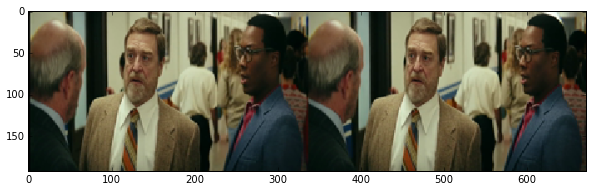

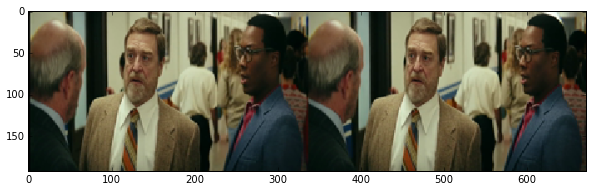

0.0 1.0 0.0 1.0
(6, 192, 672, 3)


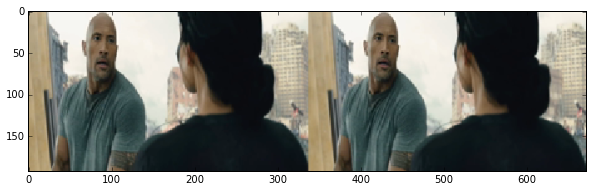

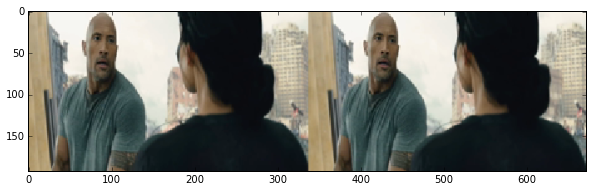

0.0 1.0 0.0 1.0


In [31]:

dat = train_generator.next()

plt.figure(figsize=(10,10))
plt.imshow(dat[0][0,...])
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(dat[1][0][0,...])
plt.show()

print(dat[1][0][0,...].min(), dat[1][0][0,...].max(), dat[0][0,...].min(), dat[0][0,...].max())
print(dat[0].shape)

dat = val_generator.next()

plt.figure(figsize=(10,10))
plt.imshow(dat[0][0,...])
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(dat[1][0][0,...])
plt.show()

print(dat[1][0][0,...].min(), dat[1][0][0,...].max(), dat[0][0,...].min(), dat[0][0,...].max())



we are ready to start training. Lets make use of Keras' nice API for training and tracking progress:

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, ProgbarLogger

model_name = 'models/w_net_FINAL_REG_V4'
model_yaml = unet_model.to_yaml()
with open(model_name + ".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

for epoch in range(100):
    try:
        model_name =model_name + '_epoch_{}'.format(epoch)
        unet_model.fit_generator(train_generator,
                steps_per_epoch=training_samples//batch_size,
                epochs=1,
                validation_data=val_generator,
                validation_steps=val_samples//batch_size,
                callbacks=[TensorBoard(log_dir='/tmp/deepdepth'),
                ModelCheckpoint(model_name+'.h5', monitor='loss', 
                                  verbose=0, 
                                  save_best_only=False, 
                                  save_weights_only=True, 
                                  mode='auto', period=1)],
                verbose=1)
    except Exception as e:
        print(e)
        # find the culprit corrupted image and remove it:
        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)

        batch_size = 1

        train_generator1 = train_datagen.flow_from_directory(
                'stereo_images_real_TRAIN/',
                target_size=(img_rows, 2*img_cols),
                batch_size=batch_size, 
                seed=10,
                shuffle=False,
                classes=None,
                class_mode=None)

        train_generator2 = train_datagen.flow_from_directory(
                'stereo_images_real_TRAIN/',
                target_size=(img_rows, 2*img_cols),
                batch_size=batch_size, 
                seed=10, 
                shuffle=False,
                classes=None,
                class_mode=None)

        validation_generator1 = val_datagen.flow_from_directory(
                'stereo_images_real_VAL/',
                target_size=(img_rows, 2*img_cols),
                batch_size=batch_size,
                seed=10,
                shuffle=False,
                classes=None,
                class_mode=None)

        validation_generator2 = val_datagen.flow_from_directory(
                'stereo_images_real_VAL/',
                target_size=(img_rows, 2*img_cols),
                batch_size=batch_size,
                seed=10,
                shuffle=False,
                classes=None,
                class_mode=None)
        
        def train_generator_func():
            while True:
                    X = train_generator1.next()
                    Y1 = train_generator2.next()
                    yield X, [Y1, np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4)), 
                              np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4))]

        def val_generator_func():
            while True:
                    X = validation_generator1.next()
                    Y1 = validation_generator2.next()
                    yield X, [Y1, np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4)), 
                              np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4))]

        train_generator = train_generator_func()
        val_generator = val_generator_func()
        
        training_samples = len(train_generator1.filenames)
        val_samples = len(validation_generator1.filenames)

        filenames = train_generator2.filenames
        for i in tqdm(range(training_samples )):
            try:
                dat = train_generator2.next()
                if dat is None:
                    print(dat, filenames[i])
            except:
                print('removing '+ filenames[i])
                os.remove('stereo_images_real_TRAIN/'+filenames[i])

        filenames = validation_generator1.filenames
        for i in tqdm(range(val_samples )):
            try:
                dat = validation_generator1.next()
                if dat is None:
                    print(dat, filenames[i])
            except:
                print('removing '+ filenames[i])
                os.remove('stereo_images_real_VAL/'+filenames[i])
                
                
        # reset the image generator       
        train_datagen = ImageDataGenerator(rescale=1./255)
        val_datagen = ImageDataGenerator(rescale=1./255)

        batch_size = 6

        train_generator1 = train_datagen.flow_from_directory(
                'stereo_images_real_TRAIN/',
                target_size=(img_rows, 2*img_cols),
                batch_size=batch_size, 
                seed=10,
                classes=None,
                class_mode=None)

        train_generator2 = train_datagen.flow_from_directory(
                'stereo_images_real_TRAIN/',
                target_size=(img_rows, 2*img_cols),
                batch_size=batch_size, 
                seed=10, 
                classes=None,
                class_mode=None)

        validation_generator1 = val_datagen.flow_from_directory(
                'stereo_images_real_VAL/',
                target_size=(img_rows, 2*img_cols),
                batch_size=batch_size,
                seed=10,
                classes=None,
                class_mode=None)

        validation_generator2 = val_datagen.flow_from_directory(
                'stereo_images_real_VAL/',
                target_size=(img_rows, 2*img_cols),
                batch_size=batch_size,
                seed=10,
                classes=None,
                class_mode=None)
        
        def train_generator_func():
            while True:
                    X = train_generator1.next()
                    Y1 = train_generator2.next()
                    yield X, [Y1, np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4)), 
                              np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4))]

        def val_generator_func():
            while True:
                    X = validation_generator1.next()
                    Y1 = validation_generator2.next()
                    yield X, [Y1, np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4)), 
                              np.zeros(shape=(Y1.shape[0], img_rows-4, img_cols-4))]
                    
        train_generator = train_generator_func()
        val_generator = val_generator_func()

        training_samples = len(train_generator1.filenames)
        val_samples = len(validation_generator1.filenames)



Epoch 1/1
20864/20864 [==============================] - 20184s - loss: 0.0119 - concatenate_6_loss: 0.0112 - lambda_9_loss: 0.2296 - lambda_10_loss: 0.2447 - val_loss: 0.0093 - val_concatenate_6_loss: 0.0088 - val_lambda_9_loss: 0.1887 - val_lambda_10_loss: 0.1971
Epoch 1/1
20864/20864 [==============================] - 20641s - loss: 0.0090 - concatenate_6_loss: 0.0083 - lambda_9_loss: 0.2204 - lambda_10_loss: 0.2261 - val_loss: 0.0085 - val_concatenate_6_loss: 0.0080 - val_lambda_9_loss: 0.1842 - val_lambda_10_loss: 0.1850
Epoch 1/1
17887/20864 [========================>.....] - ETA: 3013s - loss: 0.0085 - concatenate_6_loss: 0.0079 - lambda_9_loss: 0.2199 - lambda_10_loss: 0.2188

In [32]:
unet_model2, disp_map_model2 = get_unet(img_rows, img_cols, lr=1e-4)
unet_model2.load_weights('models/w_net_FINAL_REG_V4_epoch_1.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 192, 672, 3)   0                                            
____________________________________________________________________________________________________
lambda_12 (Lambda)               (None, 192, 336, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
lambda_11 (Lambda)               (None, 192, 336, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
concatenate_7 (Concatenate)      (None, 192, 336, 6)   0           lambda_11[0][0]                  
                                                                   lambda_12[0][0]         

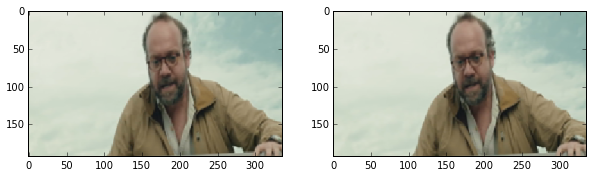

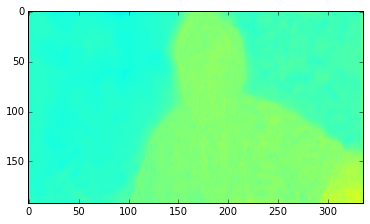

0.386681 0.000303881


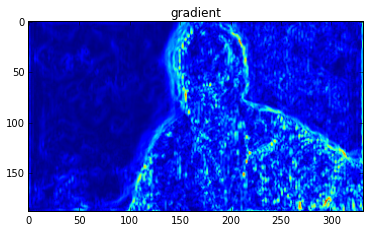

0.350426 0.00030355


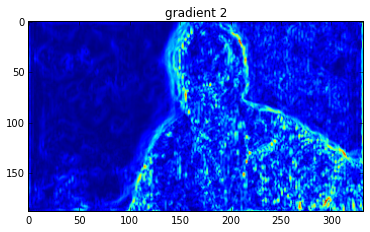

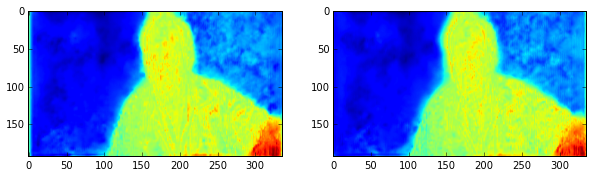

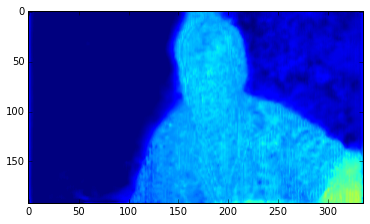

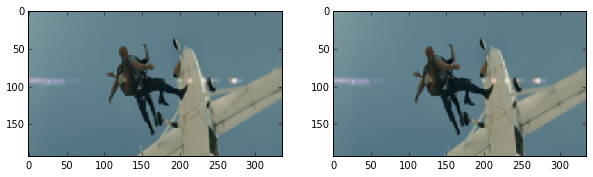

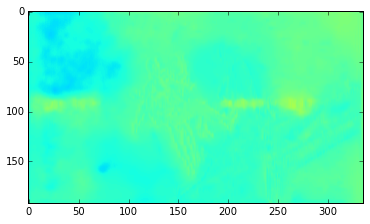

0.520927 0.00109919


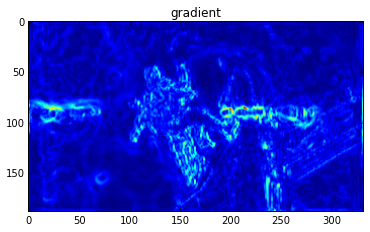

0.517611 0.00109919


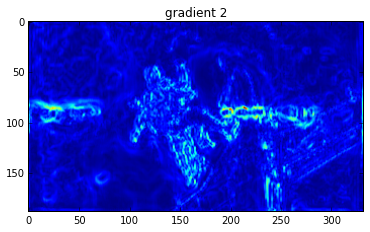

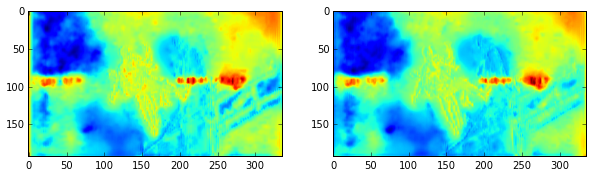

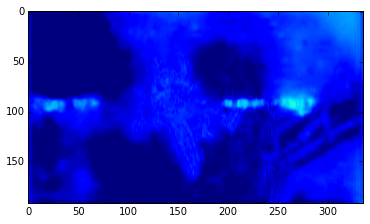

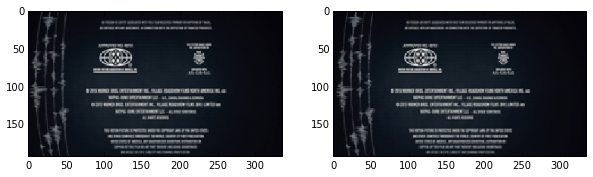

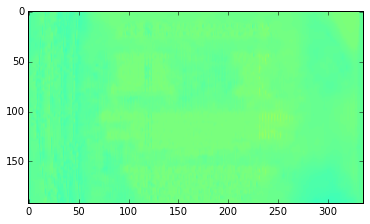

0.38234 1.68217e-07


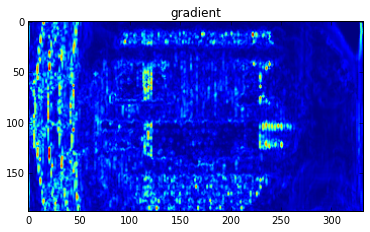

0.377796 1.68217e-07


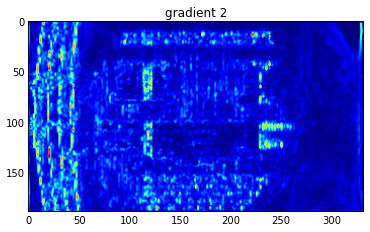

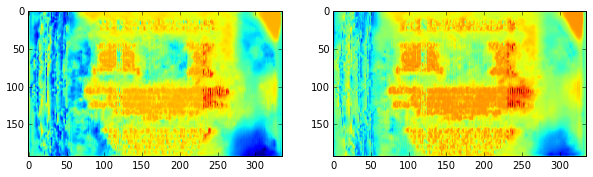

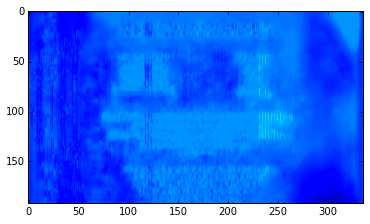

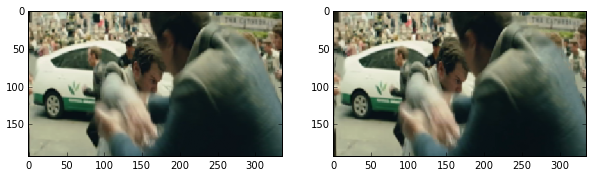

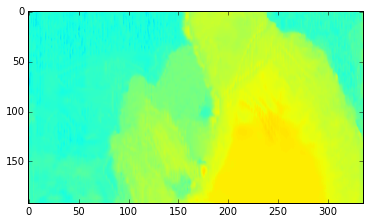

1.45469 6.7435e-07


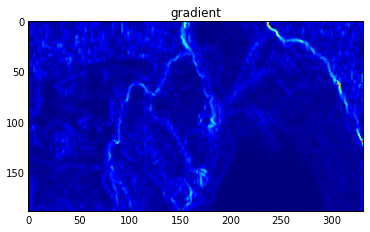

1.37516 6.7435e-07


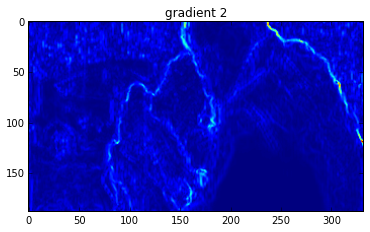

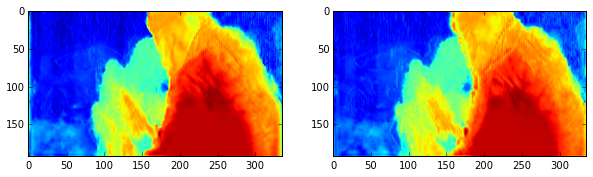

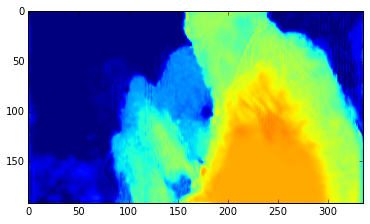

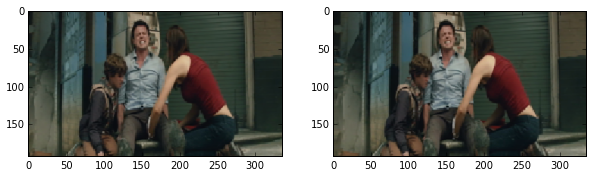

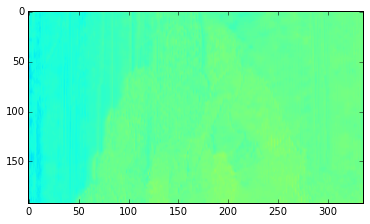

0.726891 0.00172662


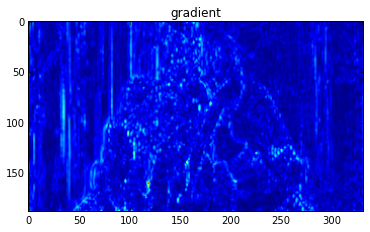

0.714593 0.0017047


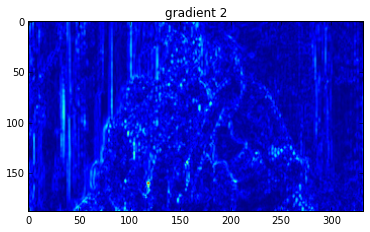

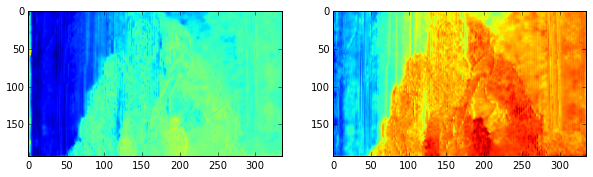

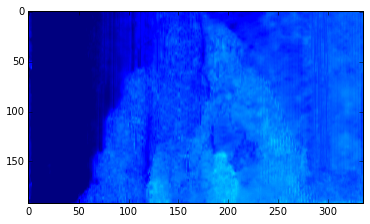

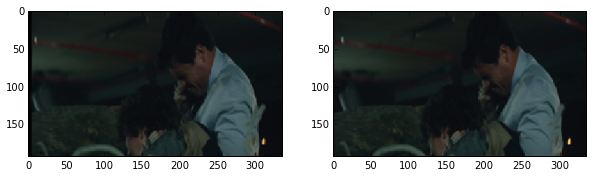

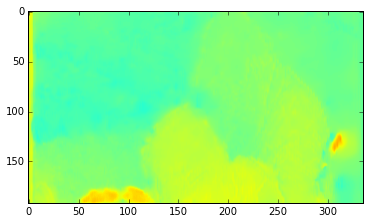

1.08891 0.000847452


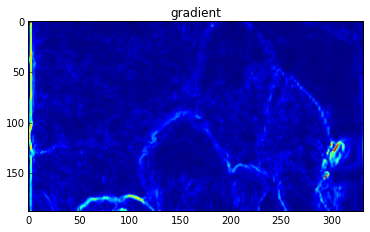

1.04918 0.000846309


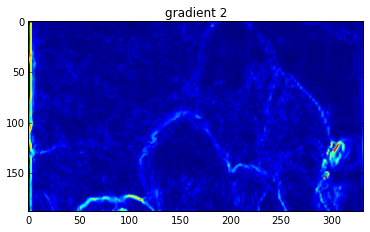

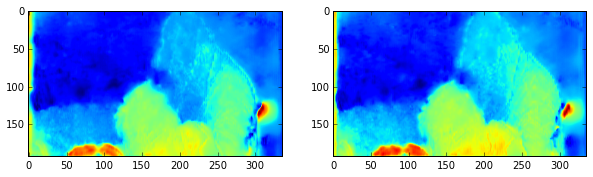

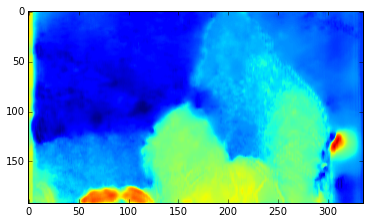

ValueError: need more than 0 values to unpack

In [41]:
dat = val_generator.next()
depthLayer = Depth(disparity_levels=range(-16,16))
depthLayer.build((None,img_rows,img_cols,16))

gradientLayer = Gradient()
gradientLayer.build((None,img_rows,img_cols))

for im_indice  in range(16):

    left_image = dat[0][im_indice:im_indice+1,...,:img_cols,:]
    right_image = dat[0][im_indice:im_indice+1,...,img_cols:,:]
    predict_left_right_image, gradient_left, gradient_right = unet_model2.predict(dat[0][im_indice:im_indice+1])
    disparity_map_left, disparity_map_right = disp_map_model2.predict(dat[0][im_indice:im_indice+1])
    
    predict_left_image = predict_left_right_image[...,:img_cols,:]
    predict_right_image = predict_left_right_image[...,img_cols:,:]

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(predict_left_image[0])
    plt.subplot(1,2,2)
    plt.imshow(predict_right_image[0])
    plt.show()
    
    dispa_map_left = K.variable(disparity_map_right)
    depth_left_K = depthLayer.call(dispa_map_left)
    depth_left = K.eval(depth_left_K[0,...])
    
    plt.imshow(depth_left,vmin=-16, vmax=16, cmap=plt.cm.jet)
    plt.show()
    
    gradient = gradientLayer.call(depth_left_K)
    gradient = K.eval(gradient)
    print(gradient.max(), gradient.min())
    plt.imshow(gradient[0], cmap=plt.cm.jet)
    plt.title('gradient')
    plt.show()
    
    gradient = gradient_right
    print(gradient.max(), gradient.min())
    plt.imshow(gradient[0], cmap=plt.cm.jet)
    plt.title('gradient 2')
    plt.show()
    
    depthMap_left = np.zeros(disparity_map_left[0,...,0].shape)
    for i_disp, disp in zip(range(-16,16),np.rollaxis(disparity_map_left[0,...],2)):
        depthMap_left += disp*i_disp
        
    depthMap_right = np.zeros(disparity_map_right[0,...,0].shape)
    for i_disp, disp in zip(range(-16,16),np.rollaxis(disparity_map_right[0,...],2)):
        depthMap_right += disp*i_disp
    
#     plt.imshow(depthMap,vmin=-3, vmax=8, cmap=plt.cm.jet)
#     plt.show()
        
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(depthMap_left, cmap=plt.cm.jet)
    plt.subplot(1,2,2)
    plt.imshow(depthMap_right, cmap=plt.cm.jet)
    plt.show()
    
    
    plt.imshow(0.5*(depthMap_left+depthMap_right),vmin=-3, vmax=8, cmap=plt.cm.jet)
    plt.show()
        
